<a href="https://colab.research.google.com/github/divx1979/IMB_CLASSIFICATION/blob/main/Oil_Spill_CLASS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oil Spill Classification
## About Dataset
The dataset was developed by starting with satellite images of the ocean, some of which contain an oil spill and some that do not.
Images were split into sections and processed using computer vision algorithms to provide a vector of features to describe the contents of the image section or patch.
The task is, given a vector that describes the contents of a patch of a satellite image, then predicts whether the patch contains an oil spill or not, e.g. from the illegal or accidental dumping of oil in the ocean.

There are two classes and the goal is to distinguish between spill and non-spill using the features for a given ocean patch.

Non-Spill: negative case, or majority class.
Oil Spill: positive case, or minority

# Approach
Our strategy involves using a combination of oversampling techniques and robust evaluation methods to develop a model that performs well in predicting the minority class. Specifically, we use the RandomForest classifier in conjunction with SMOTE (Synthetic Minority Over-sampling Technique) for handling the class imbalance and Repeated Stratified K-Fold Cross-Validation for model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import average_precision_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer

In [2]:
da1 = pd.read_csv('/content/oil_spill.csv')

print(da1.head())

da1 = pd.DataFrame(da1)

da1.drop('f_23', axis = 1, inplace = True)
da1.drop('f_1', axis = 1, inplace = True)

   f_1    f_2      f_3     f_4  f_5       f_6    f_7   f_8      f_9  f_10  \
0    1   2558  1506.09  456.63   90   6395000  40.88  7.89  29780.0  0.19   
1    2  22325    79.11  841.03  180  55812500  51.11  1.21  61900.0  0.02   
2    3    115  1449.85  608.43   88    287500  40.42  7.34   3340.0  0.18   
3    4   1201  1562.53  295.65   66   3002500  42.40  7.97  18030.0  0.19   
4    5    312   950.27  440.86   37    780000  41.43  7.03   3350.0  0.17   

   ...     f_41      f_42     f_43     f_44   f_45  f_46      f_47   f_48  \
0  ...  2850.00   1000.00   763.16   135.46   3.73     0  33243.19  65.74   
1  ...  5750.00  11500.00  9593.48  1648.80   0.60     0  51572.04  65.73   
2  ...  1400.00    250.00   150.00    45.13   9.33     1  31692.84  65.81   
3  ...  6041.52    761.58   453.21   144.97  13.33     1  37696.21  65.67   
4  ...  1320.04    710.63   512.54   109.16   2.58     0  29038.17  65.66   

   f_49  target  
0  7.95       1  
1  6.26       0  
2  7.84       1  
3 

In [3]:
print(da1.shape)

target = da1.values[:, -1]


counter = Counter(target)
for k, v in counter.items():
  per = v/len(target) * 100
  print(k, v, per)

(937, 48)
1.0 41 4.375667022411953
0.0 896 95.62433297758804


**This result Indicate that the Positive Class i.e oil spill is a total of 41 i.e just 4% of the data and the negative class i.e no spill forms the rest percentage of the data**

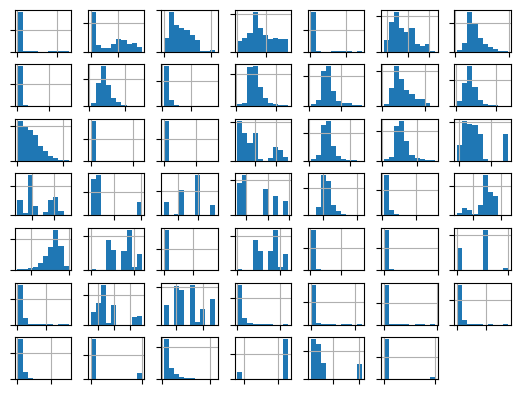

In [4]:
##hist

ax = da1.hist()

for axes in ax.flatten():
  axes.set_title('')
  axes.set_xticklabels([])
  axes.set_yticklabels([])
plt.show()

In [5]:
print(da1.describe())

                f_2          f_3          f_4         f_5           f_6  \
count    937.000000   937.000000   937.000000  937.000000  9.370000e+02   
mean     332.842049   698.707086   870.992209   84.121665  7.696964e+05   
std     1931.938570   599.965577   522.799325   45.361771  3.831151e+06   
min       10.000000     1.920000     1.000000    0.000000  7.031200e+04   
25%       20.000000    85.270000   444.200000   54.000000  1.250000e+05   
50%       65.000000   704.370000   761.280000   73.000000  1.863000e+05   
75%      132.000000  1223.480000  1260.370000  117.000000  3.304680e+05   
max    32389.000000  1893.080000  2724.570000  180.000000  7.131500e+07   

              f_7         f_8            f_9        f_10        f_11  ...  \
count  937.000000  937.000000     937.000000  937.000000  937.000000  ...   
mean    43.242721    9.127887    3940.712914    0.221003  109.892743  ...   
std     12.718404    3.588878    8167.427625    0.090316   61.460846  ...   
min     21.24000

In [6]:
## Split the data Method 1:

In [7]:
X = da1.drop('target', axis = 1)
y = da1['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [8]:
## Build Pipeline

def build_pipe(model):
  return Pipeline([
      ('sc', StandardScaler()),
      ('model', model)
  ])

##Log Reg
lr_mod1 = build_pipe(LogisticRegression(solver = 'liblinear', random_state = 42))

##Deci Tree
dt_mod2 = DecisionTreeClassifier(random_state = 42)

##SVM
svm_mod3 = build_pipe(SVC(probability = True, random_state = 42))

##RF
rf_mod4 = RandomForestClassifier(random_state = 42)

##GBM
gbm_mod5 = GradientBoostingClassifier(random_state = 42)

In [9]:
## Spot Check Alg

In [10]:
mods = {
    'Logistic Regression': lr_mod1,
    'Decision Tree': dt_mod2,
    'SVM': svm_mod3,
    'Random Forest': rf_mod4,
    'Gradient Boosting': gbm_mod5
}

for name, model in mods.items():
  model.fit(X_train, y_train)
  y_prob = model.predict_proba(X_test)[:, 1]
  pr_auc = average_precision_score(y_test, y_prob)
  print(pr_auc)

0.8715277777777778
0.40658244680851063
0.915
0.9427083333333333
0.8311965811965811


**Handle IMBClass With SMOTE(oversam) And Any 1 Model(e.g. Random Forest)**

In [11]:
## SMOTE
smote_pipe = IMBPipeline([
    ('smote', SMOTE(random_state = 1)),
    ('mod', RandomForestClassifier(random_state = 1))
])

smote_pipe.fit(X_train, y_train)
y_pred_smote = smote_pipe.predict_proba(X_test)[:, 1]
pr_au1 = average_precision_score(y_test, y_pred_smote)
print(pr_au1)

0.8795080532212884


**Hyperpara Tuning**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_mod = RandomForestClassifier(random_state=42)  # Base estimator

param_grid = { 'n_estimators': [50, 100, 200],
               'max_depth': [None, 5, 10]}  # Parameters to test

grid_search = GridSearchCV(rf_mod, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
best_m = grid_search.best_estimator_

y_pred_b1 = best_m.predict_proba(X_test)[:, 1]
auc_sc_b1 = roc_auc_score(y_test, y_pred_b1)
print(auc_sc_b1)

0.9951388888888888


**Explanation
Import Necessary Libraries: First, we import all the required libraries, including those for data manipulation, model building, evaluation, and handling imbalanced data.
Load the Dataset: Replace '/path/to/your/oil_spill.csv' with the actual path to your dataset.
Split the Data: We divide the dataset into training and testing sets to evaluate model performance.
Define Models and Pipelines: For each model, we define a pipeline that includes scaling (when applicable) and the model itself. This is important for algorithms like Logistic Regression and SVM, which are sensitive to the scale of the input features.
Spot-Check Algorithms: We fit each model to the training data and evaluate its performance on the test set using the AUROC score, a robust metric for imbalanced datasets.
Handle Imbalance with SMOTE: We demonstrate how to use SMOTE (Synthetic Minority Over-sampling Technique) with a pipeline to address class imbalance, using Random Forest as an example model.
Hyperparameter Tuning: We perform a grid search to find the optimal hyperparameters for the Random Forest model, then re-evaluate its performance with these optimized settings**

In [13]:
## USING PR-AUC INSTEAD

In [14]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

## def model

# Define a function to build pipelines for different models, integrating SMOTE for imbalance handling
def build_pipeline(model):
    return IMBPipeline([
        ('oversample', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Logistic Regression example
lr_model = build_pipeline(LogisticRegression(solver='liblinear', random_state=42))

## Uaing KFold / PR AUC

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

# Generate cross-validated estimates for each input data point
y_pred_prob = cross_val_predict(lr_model, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

# Calculate the Precision-Recall AUC
pr_auc = average_precision_score(y, y_pred_prob)
print(f'PR AUC: {pr_auc:.4f}')

PR AUC: 0.5168


In [15]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline

## def model

# Define a function to build pipelines for different models, integrating SMOTE for imbalance handling
def build_pipeline(model):
    return IMBPipeline([
        ('oversample', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Logistic Regression example
lr_model = build_pipeline(LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=42))

# Setup cross-validation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

metric = make_scorer(geometric_mean_score)

sc1 = cross_val_score(lr_model, X, y, scoring = metric, cv = cv, n_jobs = -1)

print(np.mean(sc1))


print(np.std(sc1))

0.8250058516472759
0.12737534754836669


In [17]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import average_precision_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as IMBPipeline

## def model

# Define a function to build pipelines for different models, integrating SMOTE for imbalance handling
def build_pipeline(model):
    return IMBPipeline([
        ('oversample', SMOTEENN(sampling_strategy = 0.5, random_state=42)),
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Logistic Regression example
lr_model = build_pipeline(LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=42))

# Setup cross-validation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)

metric = make_scorer(geometric_mean_score)

sc1 = cross_val_score(lr_model, X, y, scoring = metric, cv = cv, n_jobs = -1)

print(np.mean(sc1))


print(np.std(sc1))

0.8094624369492324
0.13205325489303005
